In [1]:
using HDF5, EzXML, Glob, Dates, Plots, Optim, LineSearches, LsqFit, JuMP, BayesOpt
import NLopt
include("/Users/jjc/CSF/CSF Dynamics Scripts/readCSF.jl")

datapath = "/Users/jjc/Documents/SSC/CSF Data/selected_recordings"
path = pwd();
savepath = "/Users/jjc/CSF/"
files = glob("*.hdf5", datapath);

# filename =  datapath*"/INF_20200909122333_INF2.hdf5"
# filename = datapath*"/INF_20190708150215_INF2.hdf5"
# filename = datapath*"/INF_20191010113919_INF2.hdf5"
# filename = datapath * "/INF_9CA2CCEC_E238_4CB0_99DC_78B94C06CAB9.hdf5"
# filename = datapath*"/INF_20190620142837_INF2.hdf5"
# filename = datapath * "/inf_20180329121402.hdf5"
filename = datapath * "/INF_20180829151805_INF2.hdf5"

Data = readCSF(filename)

T = Data["T"]
rec_dur_s = Data["rec_dur_s"]
start_time = Data["start_time"]
end_time = Data["end_time"]
infusion_start_frame = Data["infusion_start_frame"]
infusion_end_frame = Data["infusion_end_frame"]
plateau_start = Data["plateau_start"]
plateau_end = Data["plateau_end"]

ICP = Data["ICP"]

E = Data["E"]
# P_0 = Data["P_0"]
P_0 = 0
P_p = Data["P_p"]
P_b = Data["P_b"]
I_b = Data["I_b"]
I_inf = Data["I_inf"]
# Ibest, Eest, P0est = [I_b, E, P_0];

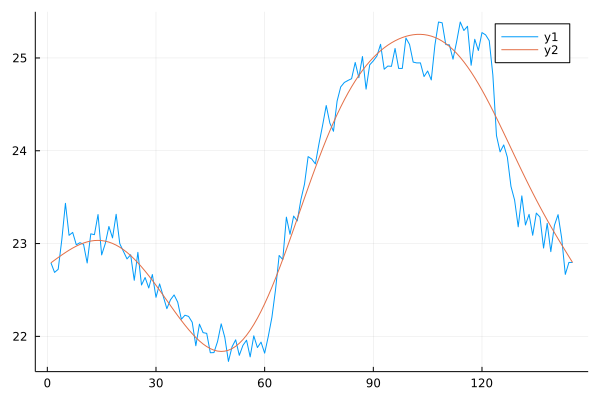

In [2]:
using DSP
plot(ICP)
responsetype = Lowpass(0.05)
designmethod = FIRWindow(hanning(128; zerophase=false))

pfilt = filtfilt(digitalfilter(responsetype, designmethod), ICP)

plot([ICP, pfilt])

In [55]:
function myerrfun(I_b::Real, E::Real, P_0::Real)
    err = 0.0
    for i = 1:length(Pm)
        tᵢ = (i - 1) / 6
        global t = tᵢ
        It = I_b + I_inf
        ΔP = P_b - P_0
        predᵢ = It * ΔP / (I_b + (I_inf * exp(-E * It * tᵢ))) + P_0
        MODVAL[i] = predᵢ
        err += (Pm[i] - predᵢ)^2
    end

    # X = [value(I_b), value(E), value(P_0)]
    # δΔP = maximum([0.0, X[3] - P_b])
    # δlb = delta.(lower .- X)
    # δlb = -log.(X .- lower)
    # δub = delta.(X .- upper)
    # δ = C .* vcat(δlb, δub, δΔP) # i = 1,⋯,q
    # # Distances do not make 100% because it will force the optimum to be in the middle lower/upper
    # dist = vcat(lower .- X, X .- upper) # Distances between the constraint and the current value
    # h = C .* abs.(dist) # i = q+1,⋯,m
    # d = vcat(δ, h)
    # penalty = sum(d .^ κ)
    # penalty = C .* sum(δlb .^ κ)
    return err
end

function f(x)
    err = 0.0
    I_b = x[1]
    E = x[2]
    P_0 = x[3]
    for i = 1:length(Pm)
        tᵢ = (i - 1) / 6
        global t = tᵢ
        It = I_b + I_inf
        ΔP = P_b - P_0
        predᵢ = It * ΔP / (I_b + (I_inf * exp(-E * It * tᵢ))) + P_0
        MODVAL[i] = predᵢ
        err += (Pm[i] - predᵢ)^2
    end
    return err
end

f (generic function with 1 method)

Method: GN_DIRECT_L
Error value:
0.6617617227564361
Estimated parameters:
Iₐ = 0.82 [mL/min]
E = 0.35 [mmHg/mL]
P₀ = 20.11 [mmHg]



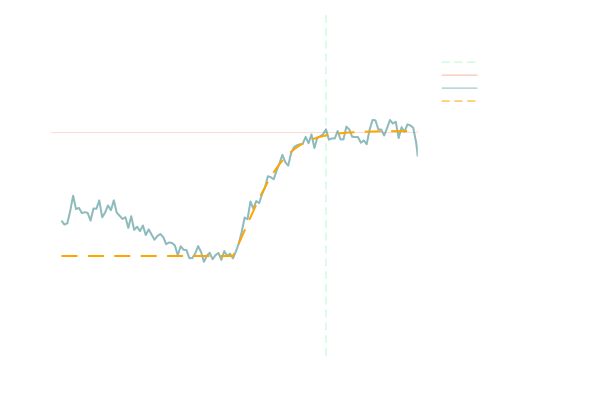

In [56]:
# Pm = ICP[infusion_start_frame:infusion_end_frame]

using DSP
plot(ICP)
responsetype = Lowpass(0.1)
designmethod = FIRWindow(hanning(128; zerophase=false))
pfilt = filtfilt(digitalfilter(responsetype, designmethod), ICP)


Pm = pfilt[infusion_start_frame:infusion_end_frame]
t = 0.0
MODVAL = zeros(length(Pm))

dsampf = 20
numsamples = length(ICP)
gg = moving_average(ICP, dsampf)
g0 = zeros(length(ICP))
g0 .+= P_b
g0[Int(dsampf / 2):Int(dsampf / 2)+length(gg)-1] = gg
g0[Int(dsampf / 2)+length(gg):end] .= P_p

# SET PARAMS FOR OPTIM
# Pm = ICP[infusion_start_frame:infusion_end_frame]
# Pm = g0[infusion_start_frame:infusion_end_frame]
lower = [0.0, 0.0, -10.0]
upper = [1.0, 1.0, P_b]
C = 10^3
κ = 1
# x0 = [Ibest, Eest, P0est]
x0 = [0.3, 0.11, 0.0]
# alglist = [:LN_NELDERMEAD, :GN_ISRES, :GN_DIRECT, :GN_DIRECT_L, :GN_DIRECT_L_RAND, :GN_CRS2_LM]
alglist = [:GN_DIRECT_L]
# alglist = [:LN_NELDERMEAD]

minerrval = 100.0
minerrmet = ""
Ibo, Eo, P0o = [0.0, 0.0, 0.0]
for optimMethod in alglist
    optalg = optimMethod
    model, I_b, E, P_0 = getModel(optalg, x0, lower, upper)
    errval = objective_value(model)
    if I_b < minerrval && I_b > 0.2
        global minerrval = I_b
        global minmet = optimMethod
        Ibo, Eo, P0o = I_b, E, P_0
    end
    println("Method: $optimMethod\nError value:\n$errval")
    # println("Estimated parameters:\nIₐ = $I_b [mL/min]\n" * "E = $E [mmHg/mL]\n" * "P₀ = $P_0 [mmHg]\n")
end

plot_model(I_b, E, P_0, ICP, dsampf, false)
# annotate!(176, 30, text("Iₐ = $(round(I_b, digits=2)) [mL/min]\n" * "E = $(round(E,digits=2)) [mmHg/mL]\n" * "P₀ = $(round(P_0,digits=2)) [mmHg]\n", :white, :left, 8))
# minerrval, minmet

Estimated parameters:
Iₐ = 0.96 [mL/min]
E = 0.32 [mmHg/mL]
P₀ = 19.82 [mmHg]



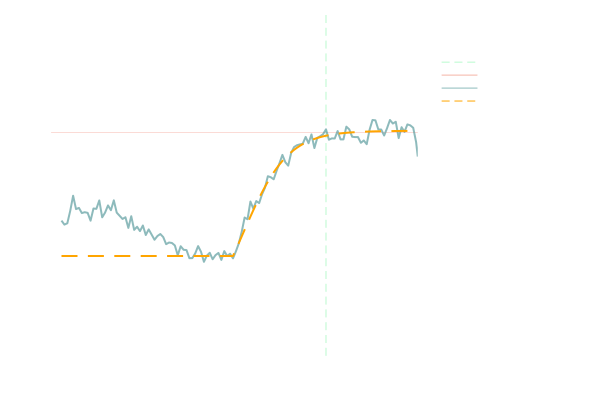

In [57]:
config = ConfigParameters()         # calls initialize_parameters_to_default of the C API
set_kernel!(config, "kMaternARD5")  # calls set_kernel of the C API
# set_kernel!(config, "kMaternISO5")  # calls set_kernel of the C API
config.sc_type = SC_MAP
config.noise = 1.0e-12
# config.l_type = L_MCMC
config.n_inner_iterations = 200
config.n_init_samples = 100
# config.random_seed = 1
config.force_jump = 10
config.verbose_level = 0



lowerbound = [0.0, 0.0, -10.0]
upperbound = [1.0, 1.0, P_b]
errvals = zeros(10)
parvals = zeros(10,3)
for i = 1:10
    config.random_seed = i
optimizer, optimum = bayes_optimization(f, lowerbound, upperbound, config)
errvals[i] = optimum
parvals[i,:]= optimizer
end

n = findmin(errvals)
optimum = n[1]
n=n[2]
optimizer = parvals[n,:]


I_b = optimizer[1]
E = optimizer[2]
P_0 = optimizer[3]
plot_model(I_b, E, P_0, ICP, dsampf, false)

Estimated parameters:
Iₐ = 1.0 [mL/min]
E = 0.31 [mmHg/mL]
P₀ = 19.72 [mmHg]



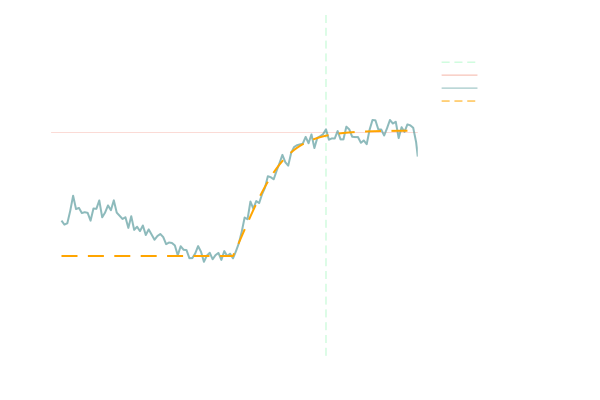

In [59]:
lower = [0.0, 0.0, -10.0]
upper = [1.0, 1.0, P_b]
C = 10^3
κ = 1
x0 = [I_b, E, P_0]
# alglist = [:LN_NELDERMEAD, :GN_ISRES, :GN_DIRECT, :GN_DIRECT_L, :GN_DIRECT_L_RAND, :GN_CRS2_LM]
# optalg = :GN_DIRECT_L
optalg = :LN_NELDERMEAD
model, I_b, E, P_0 = getModel(optalg, x0, lower, upper)
plot_model(I_b, E, P_0, ICP, dsampf, false)

In [19]:
errvals
findmin(errvals)

(37.803029344073074, 3)